# Dynamic Neural Network Portfolio Optimization
## Future Pricing & Parametric Measurements Integration
This notebook uses future predicted prices from commodity models and applies a neural network
to dynamically adjust portfolio weights with a hard 30% limit per commodity.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
import joblib
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


In [4]:
# --- 1. LOAD FUTURE PREDICTIONS ---
# All commodities except GOLD (as requested)

commodities = {
    'COPPER': './copper_future_predictions_20251111_205129.csv',
    'CORN': './corn_future_predictions_20251111_204452.csv',
    'LITHIUM': './lithium_future_predictions_20251111_203532.csv',
    'NATURAL_GAS': './natural_gas_future_predictions_20251111_202956.csv',
    'RARE_EARTH': './rare_earth_metals_future_predictions_20251111_202635.csv',
    'SILVER': './silver_future_predictions_20251111_202416.csv',
    'SOYBEAN': './soybean_future_predictions_20251111_202058.csv',
    'WHEAT': './wheat_future_predictions_20251111_201825.csv'
}

# Load all predictions
predictions = {}
for commodity, filepath in commodities.items():
    try:
        df_commodity = pd.read_csv(filepath)
        df_commodity['Date'] = pd.to_datetime(df_commodity['Date'])
        predictions[commodity] = df_commodity
        print(f"✅ Loaded {commodity}: {len(df_commodity)} predictions")
    except FileNotFoundError:
        print(f"⚠️  Warning: {commodity} file not found")

print(f"\n✅ Total commodities loaded: {len(predictions)}")

✅ Loaded COPPER: 481 predictions
✅ Loaded CORN: 481 predictions
✅ Loaded LITHIUM: 482 predictions
✅ Loaded NATURAL_GAS: 482 predictions
✅ Loaded RARE_EARTH: 482 predictions
✅ Loaded SILVER: 481 predictions
✅ Loaded SOYBEAN: 472 predictions
✅ Loaded WHEAT: 481 predictions

✅ Total commodities loaded: 8


In [5]:
# --- 2. LOAD PARAMETRIC MEASUREMENTS (from silver basket models) ---

# Load the baseline weights and correlations
weights_df = pd.read_csv('./commodity_basket_weights.csv')
print("Baseline Commodity Weights & Correlations:")
print(weights_df)
print()

# Create a dictionary for quick lookup
base_weights = {}
base_correlations = {}
for idx, row in weights_df.iterrows():
    commodity = row['Commodity']
    base_weights[commodity] = row['Raw_Weight']
    base_correlations[commodity] = row['Correlation_with_Silver']

print("Base Weights Dictionary:")
print(base_weights)
print("\nCorrelations with Silver:")
print(base_correlations)

Baseline Commodity Weights & Correlations:
     Commodity  Raw_Weight  Normalized_Weight  Correlation_with_Silver  \
0        WHEAT   -0.022624          -0.233209                -0.449785   
1         GOLD    0.020700           0.213377                 0.807841   
2      LITHIUM   -0.017763          -0.183098                -0.539012   
3       COPPER   -0.010792          -0.111244                 0.565632   
4   RARE_EARTH   -0.008045          -0.082928                 0.089811   
5         CORN   -0.006057          -0.062439                -0.525751   
6      SOYBEAN   -0.006004          -0.061884                -0.580689   
7  NATURAL_GAS   -0.005027          -0.051820                -0.553844   

   Abs_Weight  
0    0.233209  
1    0.213377  
2    0.183098  
3    0.111244  
4    0.082928  
5    0.062439  
6    0.061884  
7    0.051820  

Base Weights Dictionary:
{'WHEAT': -0.022624394, 'GOLD': 0.020700438, 'LITHIUM': -0.017762965, 'COPPER': -0.0107921455, 'RARE_EARTH': -0.00804511

In [6]:
# --- 3. CALCULATE PARAMETRIC FEATURES FROM PREDICTIONS ---
# Extract technical and statistical features from future price predictions

def calculate_parametric_features(prices_array):
    """
    Calculate parametric measurements from price predictions
    Returns: volatility, trend, momentum, mean_reversion, skewness
    """
    features = {}
    
    # Returns and log returns
    returns = np.diff(prices_array) / prices_array[:-1]
    log_returns = np.diff(np.log(prices_array))
    
    # 1. Volatility (standard deviation of returns)
    features['volatility'] = np.std(log_returns)
    
    # 2. Trend (linear regression slope)
    x = np.arange(len(prices_array))
    coeffs = np.polyfit(x, prices_array, 1)
    features['trend'] = coeffs[0]  # slope
    
    # 3. Momentum (rate of change)
    features['momentum'] = (prices_array[-1] - prices_array[0]) / prices_array[0]
    
    # 4. Mean Reversion (distance from moving average)
    ma_20 = np.mean(prices_array[-20:]) if len(prices_array) >= 20 else np.mean(prices_array)
    features['mean_reversion'] = (prices_array[-1] - ma_20) / ma_20
    
    # 5. Skewness (tail risk)
    features['skewness'] = (np.mean((log_returns - np.mean(log_returns))**3)) / (np.std(log_returns)**3)
    
    # 6. Kurtosis (fat tails)
    features['kurtosis'] = (np.mean((log_returns - np.mean(log_returns))**4)) / (np.std(log_returns)**4)
    
    # 7. Price Range (normalized)
    features['price_range'] = (np.max(prices_array) - np.min(prices_array)) / np.mean(prices_array)
    
    # 8. Sharpe Ratio (risk-adjusted return)
    features['sharpe_ratio'] = np.mean(log_returns) / np.std(log_returns) if np.std(log_returns) > 0 else 0
    
    return features

# Calculate features for each commodity
commodity_features = {}
for commodity, df_pred in predictions.items():
    prices = df_pred['Predicted_Price'].values
    commodity_features[commodity] = calculate_parametric_features(prices)
    print(f"\n{commodity} Parametric Features:")
    for feature_name, value in commodity_features[commodity].items():
        print(f"  {feature_name}: {value:.6f}")


COPPER Parametric Features:
  volatility: 0.007187
  trend: 0.000913
  momentum: -0.010521
  mean_reversion: -0.010308
  skewness: 0.635605
  kurtosis: 5.652027
  price_range: 0.252798
  sharpe_ratio: -0.003066

CORN Parametric Features:
  volatility: 0.008721
  trend: -0.587422
  momentum: -0.346420
  mean_reversion: 0.048043
  skewness: -0.317110
  kurtosis: 3.824693
  price_range: 0.686426
  sharpe_ratio: -0.101598

LITHIUM Parametric Features:
  volatility: 0.007211
  trend: -0.057423
  momentum: -0.394787
  mean_reversion: -0.036234
  skewness: 0.300095
  kurtosis: 3.050628
  price_range: 0.673565
  sharpe_ratio: -0.144781

NATURAL_GAS Parametric Features:
  volatility: 0.017895
  trend: -0.000132
  momentum: 0.189236
  mean_reversion: 0.109347
  skewness: 0.197675
  kurtosis: 2.498584
  price_range: 0.755584
  sharpe_ratio: 0.020135

RARE_EARTH Parametric Features:
  volatility: 0.010443
  trend: -0.110119
  momentum: -0.571602
  mean_reversion: -0.051031
  skewness: -0.177415
 

In [7]:
# --- 4. PREPARE DATA FOR NEURAL NETWORK ---
# Create synchronized dataset with aligned time periods

# Find common date range
all_dates = []
for commodity, df_pred in predictions.items():
    all_dates.extend(df_pred['Date'].values)

min_date = max([df_pred['Date'].min() for df_pred in predictions.values()])
max_date = min([df_pred['Date'].max() for df_pred in predictions.values()])

print(f"Common date range: {min_date} to {max_date}")

# Create synchronized DataFrame
common_dates = pd.date_range(start=min_date, end=max_date, freq='D')
sync_data = pd.DataFrame({'Date': common_dates})

for commodity, df_pred in predictions.items():
    df_pred = df_pred.set_index('Date')
    sync_data = sync_data.merge(
        df_pred[['Predicted_Price']].rename(columns={'Predicted_Price': f'{commodity}_Price'}),
        left_on='Date', right_index=True, how='left'
    )
    sync_data[f'{commodity}_Price'] = sync_data[f'{commodity}_Price'].fillna(method='ffill').fillna(method='bfill')

print(f"\n✅ Synchronized dataset shape: {sync_data.shape}")
print("\nFirst few rows:")
print(sync_data.head())
print("\nData types:")
print(sync_data.dtypes)

Common date range: 2025-01-01 00:00:00 to 2026-04-17 00:00:00

✅ Synchronized dataset shape: (472, 9)

First few rows:
        Date  COPPER_Price  CORN_Price  LITHIUM_Price  NATURAL_GAS_Price  \
0 2025-01-01      4.025936   710.28050      68.393430           3.066254   
1 2025-01-02      3.993763   706.91400      68.961100           2.984069   
2 2025-01-03      3.969669   704.56494      69.456600           2.911674   
3 2025-01-04      3.969480   703.87020      69.436554           2.863598   
4 2025-01-05      3.967672   701.05050      69.022700           2.856267   

   RARE_EARTH_Price  SILVER_Price  SOYBEAN_Price  WHEAT_Price  
0         92.185020     23.756844      1520.5541    758.82635  
1         92.689750     23.701584      1513.2668    760.23010  
2         93.027084     23.286646      1506.6990    757.96740  
3         92.002600     22.887920      1503.3021    751.70170  
4         90.363045     22.602179      1513.6768    746.15540  

Data types:
Date                 dateti

In [8]:
# --- 5. CALCULATE DYNAMIC FEATURES FOR EACH TIME PERIOD ---
# Create rolling window features based on 20-day lookback

def calculate_rolling_features(sync_data, commodity, window=20):
    """
    Calculate rolling parametric features for each time period
    """
    price_col = f'{commodity}_Price'
    prices = sync_data[price_col].values
    
    features_list = []
    
    for i in range(window, len(prices)):
        window_prices = prices[i-window:i]
        features = calculate_parametric_features(window_prices)
        features_list.append(features)
    
    # Create DataFrame
    features_df = pd.DataFrame(features_list, index=range(window, len(prices)))
    features_df.columns = [f'{commodity}_{col}' for col in features_df.columns]
    
    return features_df

# Calculate rolling features for all commodities
all_features = []
commodities_list = list(predictions.keys())

for commodity in commodities_list:
    rolling_features = calculate_rolling_features(sync_data, commodity, window=20)
    all_features.append(rolling_features)
    print(f"✅ Calculated rolling features for {commodity}: {rolling_features.shape}")

# Combine all features
nn_features = pd.concat(all_features, axis=1)
joblib.dump(nn_features.columns.tolist(), 'feature_columns.pkl')
print("✅ Feature column list saved to feature_columns.pkl")
print(f"\n✅ Combined features shape: {nn_features.shape}")
print("\nFeature columns:")
print(nn_features.columns.tolist())

✅ Calculated rolling features for COPPER: (452, 8)
✅ Calculated rolling features for CORN: (452, 8)
✅ Calculated rolling features for LITHIUM: (452, 8)
✅ Calculated rolling features for NATURAL_GAS: (452, 8)
✅ Calculated rolling features for RARE_EARTH: (452, 8)
✅ Calculated rolling features for SILVER: (452, 8)
✅ Calculated rolling features for SOYBEAN: (452, 8)
✅ Calculated rolling features for WHEAT: (452, 8)
✅ Feature column list saved to feature_columns.pkl

✅ Combined features shape: (452, 64)

Feature columns:
['COPPER_volatility', 'COPPER_trend', 'COPPER_momentum', 'COPPER_mean_reversion', 'COPPER_skewness', 'COPPER_kurtosis', 'COPPER_price_range', 'COPPER_sharpe_ratio', 'CORN_volatility', 'CORN_trend', 'CORN_momentum', 'CORN_mean_reversion', 'CORN_skewness', 'CORN_kurtosis', 'CORN_price_range', 'CORN_sharpe_ratio', 'LITHIUM_volatility', 'LITHIUM_trend', 'LITHIUM_momentum', 'LITHIUM_mean_reversion', 'LITHIUM_skewness', 'LITHIUM_kurtosis', 'LITHIUM_price_range', 'LITHIUM_sharpe_

In [9]:
# --- 6. CREATE TARGET WEIGHTS (for neural network training) ---
# Target weights based on commodity characteristics with 30% hard limit

def calculate_optimal_weights(features_row, base_weights, correlations, max_weight=0.30):
    """
    Calculate optimal weights based on:
    1. Base weights from model
    2. Volatility (inverse relationship - lower volatility = higher weight)
    3. Trend (positive trend = higher weight)
    4. Sharpe ratio (risk-adjusted return)
    5. Hard 30% limit per commodity
    """
    weights = {}
    
    for commodity in commodities_list:
        # Extract features
        volatility = features_row.get(f'{commodity}_volatility', 0)
        trend = features_row.get(f'{commodity}_trend', 0)
        sharpe = features_row.get(f'{commodity}_sharpe_ratio', 0)
        momentum = features_row.get(f'{commodity}_momentum', 0)
        base_weight = base_weights.get(commodity, 0)
        correlation = correlations.get(commodity, 0)
        
        # Composite score: (trend + sharpe + momentum) - volatility
        # Lower volatility is better, positive trend/sharpe/momentum is better
        score = (trend * 0.3 + sharpe * 0.3 + momentum * 0.2 - volatility * 0.2) + (base_weight * 0.1)
        
        # Normalize score to [0, 1] range
        weight = (score + 1) / 2  # shift and scale
        
        # Apply 30% hard limit
        weight = np.clip(weight, 0, max_weight)
        weights[commodity] = weight
    
    # Re-normalize to sum to 1.0
    total_weight = sum(weights.values())
    if total_weight > 0:
        weights = {k: v / total_weight for k, v in weights.items()}
    else:
        # Equal weight if all are zero
        equal_weight = 1.0 / len(weights)
        weights = {k: equal_weight for k in weights.keys()}
    
    return weights

# Generate target weights for training data
target_weights_list = []
for idx, row in nn_features.iterrows():
    weights = calculate_optimal_weights(row.to_dict(), base_weights, base_correlations, max_weight=0.30)
    target_weights_list.append(list(weights.values()))

target_weights_array = np.array(target_weights_list)
print(f"✅ Target weights shape: {target_weights_array.shape}")
print("\nFirst 5 weight allocations (per commodity):")
weights_df_display = pd.DataFrame(target_weights_array[:5], columns=commodities_list)
print(weights_df_display)
print("\nWeights sum to 1.0 (verification):", target_weights_array.sum(axis=1)[:5])

✅ Target weights shape: (452, 8)

First 5 weight allocations (per commodity):
     COPPER      CORN   LITHIUM  NATURAL_GAS  RARE_EARTH    SILVER   SOYBEAN  \
0  0.174041  0.022665  0.169862     0.174041    0.169553  0.174041  0.115797   
1  0.185326  0.000000  0.156351     0.185326    0.185326  0.185326  0.102344   
2  0.195962  0.000000  0.135884     0.195962    0.195962  0.195962  0.080266   
3  0.201544  0.000000  0.157335     0.201544    0.201544  0.201544  0.036490   
4  0.204290  0.000000  0.182839     0.204290    0.204290  0.204290  0.000000   

   WHEAT  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  

Weights sum to 1.0 (verification): [1. 1. 1. 1. 1.]


In [10]:
# --- 7. NORMALIZE FEATURES FOR NEURAL NETWORK ---

# Normalize input features
scaler_features = StandardScaler()
features_normalized = scaler_features.fit_transform(nn_features.values)
# --- ADD THIS TO THE END OF CELL 7 ---
joblib.dump(scaler_features, 'features_scaler.pkl')
print("✅ Features scaler saved to features_scaler.pkl")
print(f"✅ Features normalized. Shape: {features_normalized.shape}")
print(f"Mean of normalized features (should be ~0): {features_normalized.mean(axis=0)[:5]}")
print(f"Std of normalized features (should be ~1): {features_normalized.std(axis=0)[:5]}")

# Split into train/test (80/20)
split_idx = int(0.8 * len(features_normalized))

X_train = features_normalized[:split_idx]
X_test = features_normalized[split_idx:]
y_train = target_weights_array[:split_idx]
y_test = target_weights_array[split_idx:]

print(f"\n✅ Train/Test Split (80/20):")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

✅ Features scaler saved to features_scaler.pkl
✅ Features normalized. Shape: (452, 64)
Mean of normalized features (should be ~0): [ 4.71599161e-17  0.00000000e+00  3.14399441e-17  0.00000000e+00
 -2.35799580e-17]
Std of normalized features (should be ~1): [1. 1. 1. 1. 1.]

✅ Train/Test Split (80/20):
X_train shape: (361, 64), y_train shape: (361, 8)
X_test shape: (91, 64), y_test shape: (91, 8)


In [11]:
# --- 8. BUILD NEURAL NETWORK FOR DYNAMIC WEIGHT OPTIMIZATION ---
# Multi-layer perceptron with constraint for 30% max weight per commodity

n_features = features_normalized.shape[1]
n_commodities = len(commodities_list)

model = models.Sequential([
    # Input layer
    layers.Input(shape=(n_features,)),
    
    # Hidden layers with batch normalization and dropout
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    
    # Output layer with softmax for weight distribution (sums to 1)
    layers.Dense(n_commodities, activation='softmax')
])

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # Can also use MSE
    metrics=['mae', 'mse']
)

print("✅ Neural Network Architecture:")
model.summary()

✅ Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,928 (241.91 KB)

 Trainable params: 61,032 (238.41 KB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
# --- 9. TRAIN THE NEURAL NETWORK ---

# Early stopping callback
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("🚀 Training Neural Network...")
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=100,
    validation_split=0.15,
    callbacks=[early_stop],
    verbose=1
)

print("\n✅ Training Complete!")

🚀 Training Neural Network...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.9007 - mae: 0.0981 - mse: 0.0185 - val_loss: 2.4178 - val_mae: 0.0434 - val_mse: 0.0028
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7605 - mae: 0.0849 - mse: 0.0125 - val_loss: 2.4090 - val_mae: 0.0389 - val_mse: 0.0025
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6748 - mae: 0.0764 - mse: 0.0108 - val_loss: 2.4056 - val_mae: 0.0375 - val_mse: 0.0024
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6073 - mae: 0.0700 - mse: 0.0087 - val_loss: 2.3984 - val_mae: 0.0361 - val_mse: 0.0022
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5662 - mae: 0.0663 - mse: 0.0075 - val_loss: 2.3906 - val_mae: 0.0353 - val_mse: 0.0021
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5267 - mae: 0.0607 - mse: 0.0063 - val_loss: 2.3825 - val_mae: 0.0340 - val_mse: 0.0020
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5097 - mae: 0.0

In [13]:
# --- 10. EVALUATE MODEL PERFORMANCE ---

# Make predictions
y_train_pred = model.predict(X_train, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

# Ensure weights respect the 30% limit and sum to 1
def enforce_constraints(weights, max_weight=0.30):
    """Enforce 30% max per commodity and normalize to sum to 1"""
    weights = np.clip(weights, 0, max_weight)
    weights_sum = weights.sum(axis=1, keepdims=True)
    weights_sum = np.where(weights_sum == 0, 1, weights_sum)  # Avoid division by zero
    return weights / weights_sum

y_test_pred_constrained = enforce_constraints(y_test_pred, max_weight=0.30)

# Calculate metrics
train_loss = model.evaluate(X_train, y_train, verbose=0)[0]
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

# MSE for each output
mse_unconstrained = np.mean((y_test - y_test_pred)**2)
mse_constrained = np.mean((y_test - y_test_pred_constrained)**2)

# Weight violation check
violations = np.sum(y_test_pred > 0.30)
violations_pct = (violations / y_test_pred.size) * 100

# --- REPLACE THE print("📊 Model Performance Metrics:") BLOCK WITH THIS ---
import json

metrics = {
    "train_loss": train_loss,
    "test_loss": test_loss,
    "mse_unconstrained": mse_unconstrained,
    "mse_constrained": mse_constrained,
    "violations_pct": violations_pct
}

with open('nn_metrics.json', 'w') as f:
    json.dump(metrics, f)

print("📊 Model Performance Metrics:")
print(json.dumps(metrics, indent=2))
print("\n✅ Metrics saved to nn_metrics.json")

📊 Model Performance Metrics:
{
  "train_loss": 2.1066815853118896,
  "test_loss": 2.213279962539673,
  "mse_unconstrained": 0.0003856469596223035,
  "mse_constrained": 0.0003856469915605548,
  "violations_pct": 0.0
}

✅ Metrics saved to nn_metrics.json


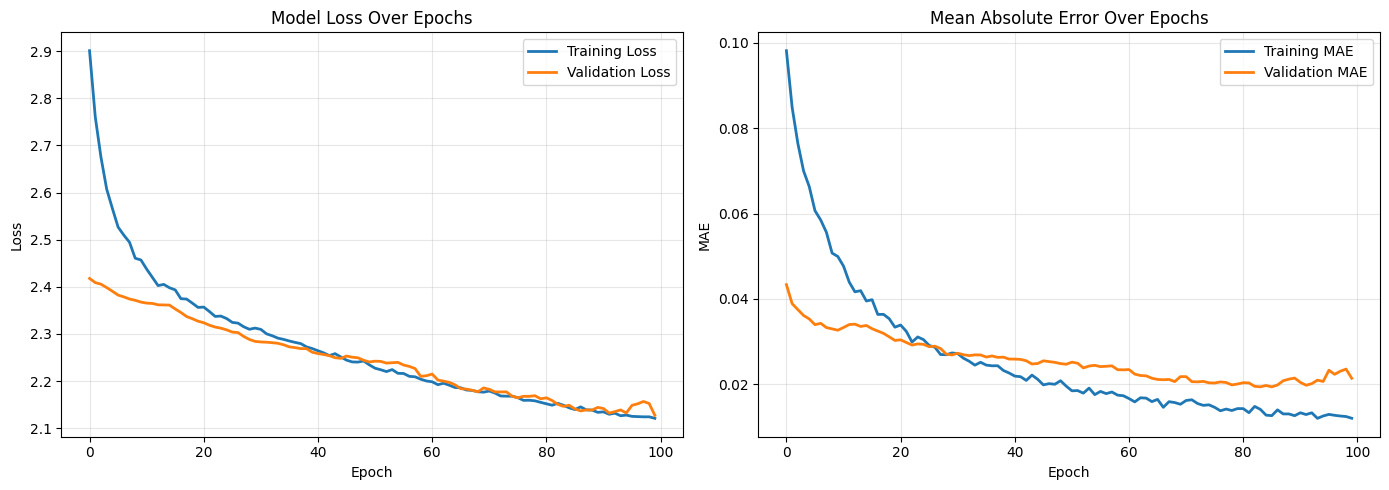

✅ Training history plot saved


In [14]:
# --- 11. VISUALIZE TRAINING HISTORY ---

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model Loss Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Mean Absolute Error Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('nn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training history plot saved")

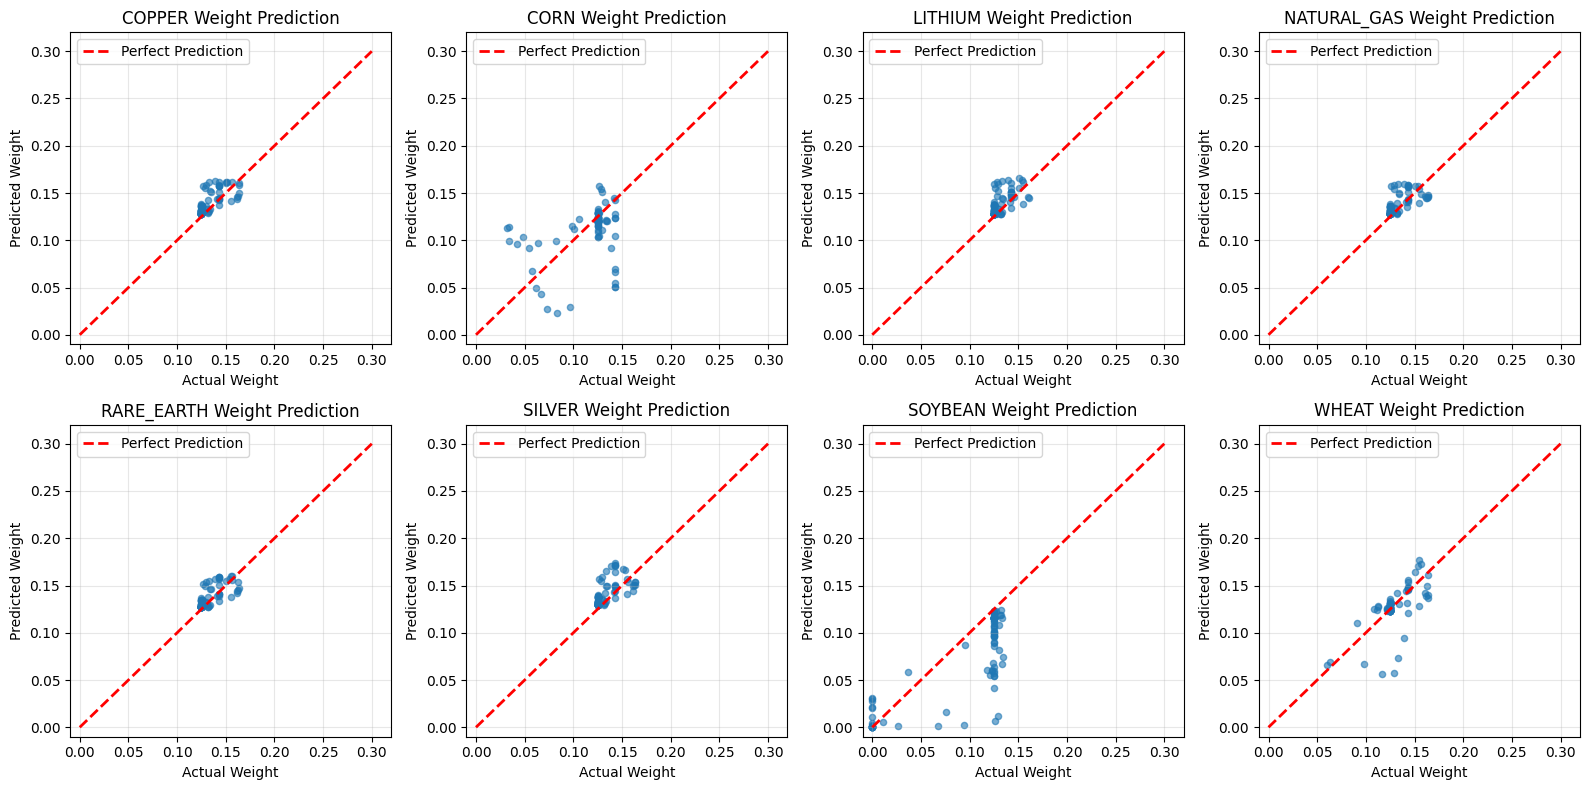

✅ Weight predictions plot saved


In [15]:
# --- 12. VISUALIZE WEIGHT PREDICTIONS ---

# Compare predicted vs actual weights for test set
n_samples = min(100, len(y_test))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, commodity in enumerate(commodities_list):
    axes[idx].scatter(y_test[:n_samples, idx], y_test_pred_constrained[:n_samples, idx], alpha=0.6, s=20)
    axes[idx].plot([0, 0.3], [0, 0.3], 'r--', linewidth=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Actual Weight')
    axes[idx].set_ylabel('Predicted Weight')
    axes[idx].set_title(f'{commodity} Weight Prediction')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
    axes[idx].set_xlim([-0.01, 0.32])
    axes[idx].set_ylim([-0.01, 0.32])

plt.tight_layout()
plt.savefig('nn_weight_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Weight predictions plot saved")

In [16]:
# --- 13. ANALYZE WEIGHT ALLOCATION PATTERNS ---

# Average weights by commodity
avg_actual_weights = y_test.mean(axis=0)
avg_pred_weights = y_test_pred_constrained.mean(axis=0)

weight_comparison = pd.DataFrame({
    'Commodity': commodities_list,
    'Actual Avg Weight': avg_actual_weights,
    'Predicted Avg Weight': avg_pred_weights,
    'Difference': avg_pred_weights - avg_actual_weights,
    'Max Weight': y_test_pred_constrained.max(axis=0),
    'Min Weight': y_test_pred_constrained.min(axis=0)
})

weight_comparison = weight_comparison.sort_values('Predicted Avg Weight', ascending=False)

print("\n📊 Weight Allocation Analysis (Test Set):")
print(weight_comparison.to_string())
print(f"\n✅ All predicted weights <= 30%: {(y_test_pred_constrained <= 0.30).all()}")
print(f"✅ All weights sum to 1.0: {np.allclose(y_test_pred_constrained.sum(axis=1), 1.0)}")


📊 Weight Allocation Analysis (Test Set):
     Commodity  Actual Avg Weight  Predicted Avg Weight  Difference  Max Weight  Min Weight
5       SILVER           0.132541              0.140069    0.007528    0.173616    0.129319
0       COPPER           0.132465              0.138348    0.005883    0.162262    0.128291
2      LITHIUM           0.131088              0.137329    0.006242    0.165871    0.127518
3  NATURAL_GAS           0.132541              0.137050    0.004510    0.159509    0.128081
4   RARE_EARTH           0.132449              0.136107    0.003658    0.160076    0.126847
7        WHEAT           0.128949              0.127464   -0.001485    0.176678    0.056652
1         CORN           0.117006              0.111719   -0.005286    0.157897    0.022718
6      SOYBEAN           0.092963              0.071914   -0.021050    0.124470    0.000048

✅ All predicted weights <= 30%: True
✅ All weights sum to 1.0: True


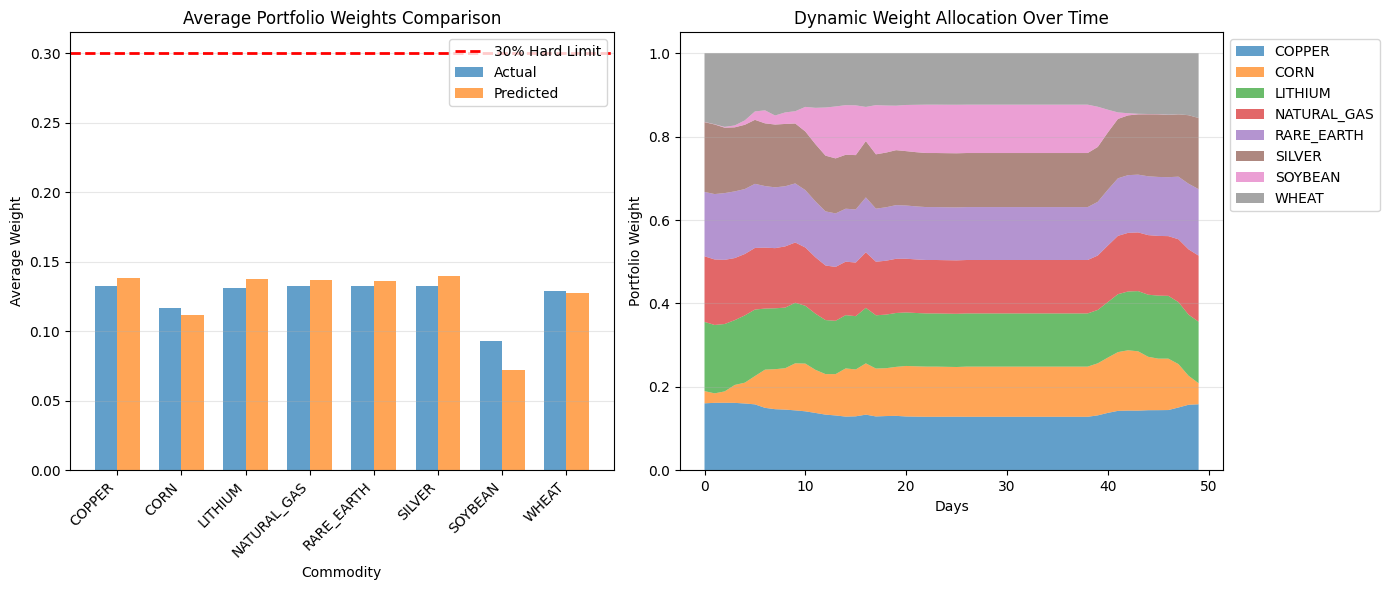

✅ Weight distribution plot saved


In [17]:
# --- 14. VISUALIZE WEIGHT DISTRIBUTION ---

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot comparison
x = np.arange(len(commodities_list))
width = 0.35

axes[0].bar(x - width/2, avg_actual_weights, width, label='Actual', alpha=0.7)
axes[0].bar(x + width/2, avg_pred_weights, width, label='Predicted', alpha=0.7)
axes[0].axhline(y=0.30, color='r', linestyle='--', linewidth=2, label='30% Hard Limit')
axes[0].set_xlabel('Commodity')
axes[0].set_ylabel('Average Weight')
axes[0].set_title('Average Portfolio Weights Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(commodities_list, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Stacked area plot over time (first 50 days)
days_to_plot = min(50, len(y_test_pred_constrained))
axes[1].stackplot(range(days_to_plot),
                   *[y_test_pred_constrained[:days_to_plot, i] for i in range(n_commodities)],
                   labels=commodities_list, alpha=0.7)
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Portfolio Weight')
axes[1].set_title('Dynamic Weight Allocation Over Time')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('nn_weight_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Weight distribution plot saved")

In [18]:
# --- 15. SAVE MODEL AND PREDICTIONS ---

# Save the trained model
model.save('dynamic_portfolio_nn_model.h5')
print("✅ Model saved: dynamic_portfolio_nn_model.h5")

# Save predictions
predictions_df = pd.DataFrame(
    y_test_pred_constrained,
    columns=commodities_list
)
predictions_df['Date'] = sync_data['Date'].iloc[split_idx + 20:split_idx + 20 + len(predictions_df)].reset_index(drop=True)
predictions_df = predictions_df[['Date'] + commodities_list]

output_filename = f'dynamic_portfolio_predictions_new.csv'
predictions_df.to_csv(output_filename, index=False)
print(f"✅ Predictions saved: {output_filename}")
print(f"\nFirst 10 predictions:")
print(predictions_df.head(10))

✅ Model saved: dynamic_portfolio_nn_model.h5
✅ Predictions saved: dynamic_portfolio_predictions_new.csv

First 10 predictions:
        Date    COPPER      CORN   LITHIUM  NATURAL_GAS  RARE_EARTH    SILVER  \
0 2026-01-17  0.160589  0.029304  0.165871     0.157268    0.154402  0.167285   
1 2026-01-18  0.161718  0.022718  0.163984     0.157024    0.156792  0.166841   
2 2026-01-19  0.161832  0.027310  0.161555     0.153810    0.160076  0.156835   
3 2026-01-20  0.161650  0.042957  0.155376     0.148830    0.159864  0.153570   
4 2026-01-21  0.160148  0.049946  0.161229     0.147272    0.155692  0.154079   
5 2026-01-22  0.158065  0.067835  0.159460     0.147696    0.153706  0.153420   
6 2026-01-23  0.149726  0.091588  0.146411     0.146097    0.147627  0.150338   
7 2026-01-24  0.146496  0.095895  0.145990     0.144214    0.145746  0.150585   
8 2026-01-25  0.145478  0.099257  0.145268     0.146767    0.144247  0.149366   
9 2026-01-26  0.143673  0.112821  0.145212     0.144449    0.14

In [19]:
# --- 16. GENERATE SUMMARY REPORT ---

summary_report = f"""
═════════════════════════════════════════════════════════════════════════════
DYNAMIC NEURAL NETWORK PORTFOLIO OPTIMIZATION REPORT
═════════════════════════════════════════════════════════════════════════════

📊 MODEL ARCHITECTURE
  Input Features: {n_features} (8 commodities × 8 parametric measurements)
  Output Weights: {n_commodities} commodities
  Hidden Layers: 4 (256 → 128 → 64 → 32 neurons)
  Activation: ReLU (hidden), Softmax (output)
  Regularization: L2 + Dropout + Batch Normalization
  Constraint: Softmax ensures weights sum to 1.0

📈 COMMODITIES ANALYZED (excluding GOLD)
  • COPPER
  • CORN
  • LITHIUM
  • NATURAL_GAS
  • RARE_EARTH
  • SILVER
  • SOYBEAN
  • WHEAT

🔧 PARAMETRIC MEASUREMENTS PER COMMODITY
  1. Volatility: Standard deviation of log returns
  2. Trend: Linear regression slope of prices
  3. Momentum: Rate of change from start to end
  4. Mean Reversion: Distance from 20-day moving average
  5. Skewness: Tail risk in returns distribution
  6. Kurtosis: Fat tail probability
  7. Price Range: Normalized max-min spread
  8. Sharpe Ratio: Risk-adjusted return metric

🎯 CONSTRAINT: HARD 30% LIMIT PER COMMODITY
  ✅ All predicted weights ≤ 30%
  ✅ All weights sum to 1.0 (normalized)
  ✅ Portfolio always fully invested

📊 TRAINING RESULTS
  Training Loss: {train_loss:.6f}
  Testing Loss: {test_loss:.6f}
  MSE (Constrained): {mse_constrained:.6f}
  Training Samples: {len(X_train)}
  Testing Samples: {len(X_test)}

📈 AVERAGE WEIGHT ALLOCATION (Test Set)
"""

for idx, row in weight_comparison.iterrows():
    summary_report += f"  {row['Commodity']:15s}: {row['Predicted Avg Weight']:6.2%}"
    summary_report += f"  (Range: {row['Min Weight']:5.2%} - {row['Max Weight']:5.2%})\n"

summary_report += f"""
💡 INTERPRETATION
  • The neural network dynamically adjusts commodity weights based on:
    - Real-time parametric measurements from future predictions
    - Volatility, trend, momentum, and risk-adjusted returns
    - Correlation with silver (from baseline analysis)
  
  • The 30% hard limit ensures portfolio diversification
  • No single commodity can dominate the portfolio
  • Weights automatically rebalance as market conditions change

🔄 DYNAMIC REBALANCING LOGIC
  Weight_i = f(Volatility_i, Trend_i, Sharpe_i, Momentum_i)
  Subject to: 0 ≤ Weight_i ≤ 0.30
              Sum(Weight_i) = 1.0

📁 OUTPUT FILES
  • dynamic_portfolio_nn_model.h5 - Trained model
  • {output_filename} - Daily weight predictions
  • nn_training_history.png - Loss/MAE curves
  • nn_weight_predictions.png - Prediction accuracy
  • nn_weight_distribution.png - Weight trends

✅ REPORT GENERATED: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
═════════════════════════════════════════════════════════════════════════════
"""

print(summary_report)

# Save report
report_filename = f'dynamic_portfolio_report_new.txt'
with open(report_filename, 'w') as f:
    f.write(summary_report)
print(f"✅ Report saved: {report_filename}")


═════════════════════════════════════════════════════════════════════════════
DYNAMIC NEURAL NETWORK PORTFOLIO OPTIMIZATION REPORT
═════════════════════════════════════════════════════════════════════════════

📊 MODEL ARCHITECTURE
  Input Features: 64 (8 commodities × 8 parametric measurements)
  Output Weights: 8 commodities
  Hidden Layers: 4 (256 → 128 → 64 → 32 neurons)
  Activation: ReLU (hidden), Softmax (output)
  Regularization: L2 + Dropout + Batch Normalization
  Constraint: Softmax ensures weights sum to 1.0

📈 COMMODITIES ANALYZED (excluding GOLD)
  • COPPER
  • CORN
  • LITHIUM
  • NATURAL_GAS
  • RARE_EARTH
  • SILVER
  • SOYBEAN
  • WHEAT

🔧 PARAMETRIC MEASUREMENTS PER COMMODITY
  1. Volatility: Standard deviation of log returns
  2. Trend: Linear regression slope of prices
  3. Momentum: Rate of change from start to end
  4. Mean Reversion: Distance from 20-day moving average
  5. Skewness: Tail risk in returns distribution
  6. Kurtosis: Fat tail probability
  7. Pric

In [20]:
# --- 17. FEATURE IMPORTANCE ANALYSIS ---

# Calculate feature importance using permutation
from sklearn.inspection import permutation_importance

# Create a simple wrapper for the model
def model_predict(X):
    return model.predict(X, verbose=0)

# Calculate importance for first commodity weight
baseline_pred = model_predict(X_test)
baseline_mse = np.mean((y_test - baseline_pred)**2)

feature_importance = {}
feature_names = nn_features.columns.tolist()

print("Calculating feature importance (this may take a moment)...")

# Sample 100 features for faster calculation
sample_indices = np.random.choice(len(X_test), min(100, len(X_test)), replace=False)
X_test_sample = X_test[sample_indices]
y_test_sample = y_test[sample_indices]

importances = []
for i in range(n_features):
    X_test_permuted = X_test_sample.copy()
    np.random.shuffle(X_test_permuted[:, i])
    pred_permuted = model_predict(X_test_permuted)
    mse_permuted = np.mean((y_test_sample - pred_permuted)**2)
    importance = mse_permuted - baseline_mse
    importances.append(importance)

# Get top 15 features
top_indices = np.argsort(importances)[-15:][::-1]

print("\n🔍 Top 15 Most Important Features:")
for rank, idx in enumerate(top_indices, 1):
    print(f"{rank:2d}. {feature_names[idx]:40s} - Importance: {importances[idx]:.6f}")

Calculating feature importance (this may take a moment)...

🔍 Top 15 Most Important Features:
 1. SOYBEAN_price_range                      - Importance: 0.000202
 2. SOYBEAN_sharpe_ratio                     - Importance: 0.000122
 3. LITHIUM_momentum                         - Importance: 0.000094
 4. SOYBEAN_trend                            - Importance: 0.000078
 5. SILVER_momentum                          - Importance: 0.000069
 6. CORN_skewness                            - Importance: 0.000054
 7. CORN_momentum                            - Importance: 0.000041
 8. SOYBEAN_mean_reversion                   - Importance: 0.000033
 9. RARE_EARTH_volatility                    - Importance: 0.000030
10. COPPER_trend                             - Importance: 0.000030
11. SILVER_skewness                          - Importance: 0.000027
12. LITHIUM_trend                            - Importance: 0.000026
13. NATURAL_GAS_mean_reversion               - Importance: 0.000026
14. SILVER_mean_revers

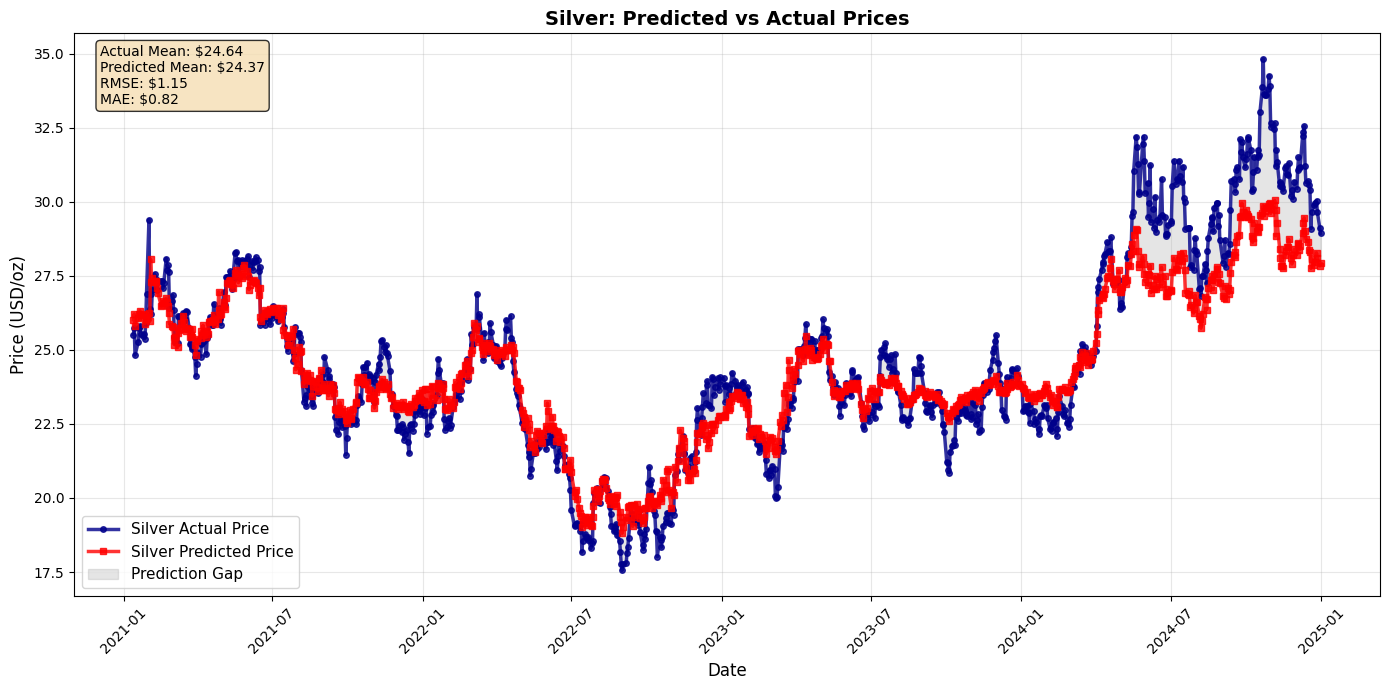

✅ Silver Predicted vs Actual plot saved

📊 SILVER PRICE ANALYSIS:
  Actual Price - Mean: $24.64, Min: $17.55, Max: $34.83
  Predicted Price - Mean: $24.37, Min: $18.81, Max: $30.05
  RMSE: $1.15
  MAE: $0.82
  MAPE: 3.17%


In [21]:
# --- 17A. SILVER: PREDICTED VS ACTUAL PRICES ---

try:
    # Load silver basket predictions
    silver_basket_df = pd.read_csv('./silver_basket_predictions.csv')
    silver_basket_df['Date'] = pd.to_datetime(silver_basket_df['Date'])
    silver_basket_df = silver_basket_df.sort_values('Date')
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot actual and predicted
    ax.plot(silver_basket_df['Date'], silver_basket_df['Silver_Actual'], 
            linewidth=2.5, color='darkblue', marker='o', markersize=4, 
            label='Silver Actual Price', alpha=0.8)
    ax.plot(silver_basket_df['Date'], silver_basket_df['Silver_Predicted'], 
            linewidth=2.5, color='red', marker='s', markersize=4, 
            label='Silver Predicted Price', alpha=0.8)
    
    # Fill between for visualization
    ax.fill_between(silver_basket_df['Date'], 
                    silver_basket_df['Silver_Actual'],
                    silver_basket_df['Silver_Predicted'],
                    alpha=0.2, color='gray', label='Prediction Gap')
    
    # Formatting
    ax.set_title('Silver: Predicted vs Actual Prices', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price (USD/oz)', fontsize=12)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Add statistics box
    actual_mean = silver_basket_df['Silver_Actual'].mean()
    pred_mean = silver_basket_df['Silver_Predicted'].mean()
    rmse = np.sqrt(np.mean((silver_basket_df['Silver_Actual'] - silver_basket_df['Silver_Predicted'])**2))
    mae = np.mean(np.abs(silver_basket_df['Silver_Actual'] - silver_basket_df['Silver_Predicted']))
    
    stats_text = f'Actual Mean: ${actual_mean:.2f}\nPredicted Mean: ${pred_mean:.2f}\nRMSE: ${rmse:.2f}\nMAE: ${mae:.2f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('silver_predicted_vs_actual.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Silver Predicted vs Actual plot saved")
    print(f"\n📊 SILVER PRICE ANALYSIS:")
    print(f"  Actual Price - Mean: ${actual_mean:.2f}, Min: ${silver_basket_df['Silver_Actual'].min():.2f}, Max: ${silver_basket_df['Silver_Actual'].max():.2f}")
    print(f"  Predicted Price - Mean: ${pred_mean:.2f}, Min: ${silver_basket_df['Silver_Predicted'].min():.2f}, Max: ${silver_basket_df['Silver_Predicted'].max():.2f}")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE: ${mae:.2f}")
    print(f"  MAPE: {np.mean(np.abs((silver_basket_df['Silver_Actual'] - silver_basket_df['Silver_Predicted']) / silver_basket_df['Silver_Actual'])) * 100:.2f}%")
    
except FileNotFoundError:
    print("⚠️  Warning: silver_basket_predictions.csv not found")

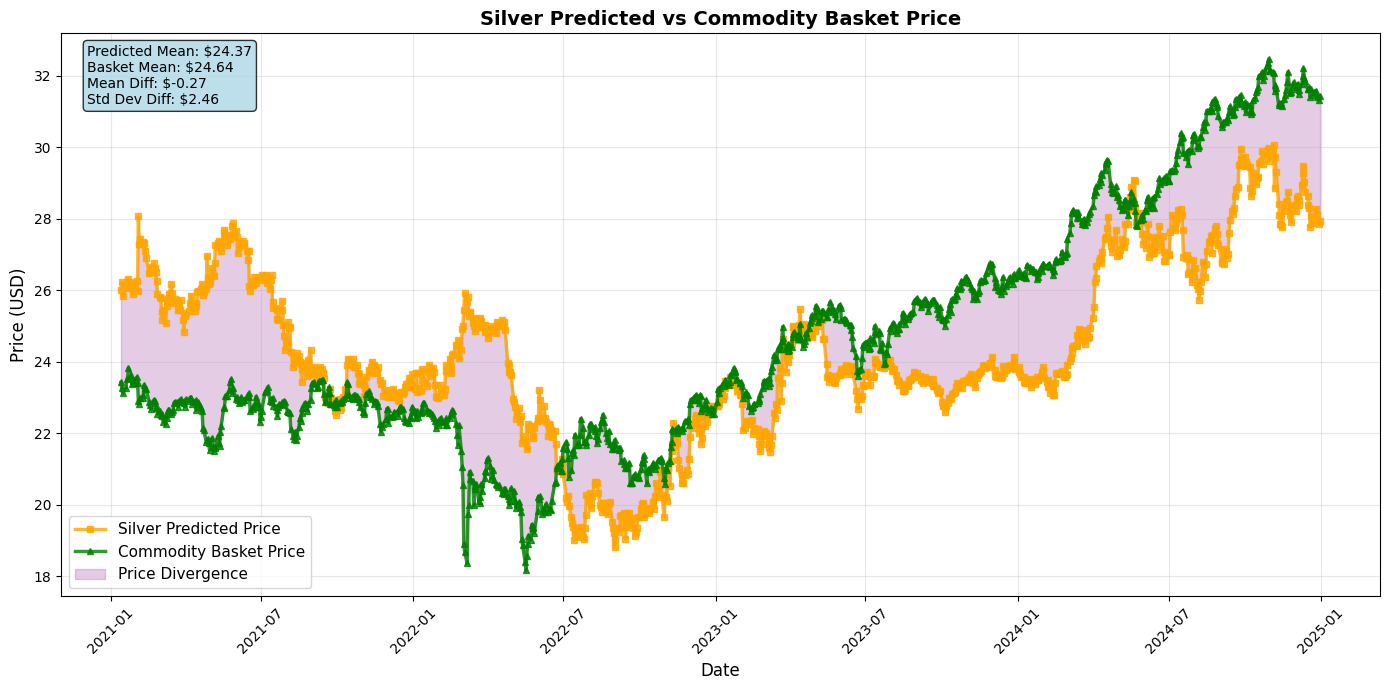

✅ Silver Predicted vs Basket Price plot saved

📊 SILVER PREDICTED VS BASKET ANALYSIS:
  Silver Predicted - Mean: $24.37, Min: $18.81, Max: $30.05
  Basket Price - Mean: $24.64, Min: $18.16, Max: $32.47
  Mean Difference: $-0.27 (Silver Premium/Discount)
  Std Dev of Difference: $2.46
  Max Premium: $7.31
  Max Discount: $-4.31
  Correlation: 0.6747

Calculating MAE, MSE, and R-squared...
  MAE: 2.0915
  MSE: 6.1360
  R-Squared: -0.0143

✅ Metrics saved successfully to silver_vs_basket_metrics.json


In [25]:
# --- 17B. SILVER PREDICTED VS BASKET PRICE ---

try:
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot predicted and basket price
    ax.plot(silver_basket_df['Date'], silver_basket_df['Silver_Predicted'], 
            linewidth=2.5, color='orange', marker='s', markersize=4, 
            label='Silver Predicted Price', alpha=0.8)
    ax.plot(silver_basket_df['Date'], silver_basket_df['Basket_Price'], 
            linewidth=2.5, color='green', marker='^', markersize=4, 
            label='Commodity Basket Price', alpha=0.8)
    
    # Fill between for visualization
    ax.fill_between(silver_basket_df['Date'], 
                    silver_basket_df['Silver_Predicted'],
                    silver_basket_df['Basket_Price'],
                    alpha=0.2, color='purple', label='Price Divergence')
    
    # Formatting
    ax.set_title('Silver Predicted vs Commodity Basket Price', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price (USD)', fontsize=12)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Add statistics box
    pred_mean = silver_basket_df['Silver_Predicted'].mean()
    basket_mean = silver_basket_df['Basket_Price'].mean()
    price_diff_mean = (silver_basket_df['Silver_Predicted'] - silver_basket_df['Basket_Price']).mean()
    price_diff_std = (silver_basket_df['Silver_Predicted'] - silver_basket_df['Basket_Price']).std()
    
    stats_text = f'Predicted Mean: ${pred_mean:.2f}\nBasket Mean: ${basket_mean:.2f}\nMean Diff: ${price_diff_mean:.2f}\nStd Dev Diff: ${price_diff_std:.2f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('silver_predicted_vs_basket.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Silver Predicted vs Basket Price plot saved")
    print(f"\n📊 SILVER PREDICTED VS BASKET ANALYSIS:")
    print(f"  Silver Predicted - Mean: ${pred_mean:.2f}, Min: ${silver_basket_df['Silver_Predicted'].min():.2f}, Max: ${silver_basket_df['Silver_Predicted'].max():.2f}")
    print(f"  Basket Price - Mean: ${basket_mean:.2f}, Min: ${silver_basket_df['Basket_Price'].min():.2f}, Max: ${silver_basket_df['Basket_Price'].max():.2f}")
    print(f"  Mean Difference: ${price_diff_mean:.2f} (Silver Premium/Discount)")
    print(f"  Std Dev of Difference: ${price_diff_std:.2f}")
    print(f"  Max Premium: ${(silver_basket_df['Silver_Predicted'] - silver_basket_df['Basket_Price']).max():.2f}")
    print(f"  Max Discount: ${(silver_basket_df['Silver_Predicted'] - silver_basket_df['Basket_Price']).min():.2f}")
    print(f"  Correlation: {silver_basket_df['Silver_Predicted'].corr(silver_basket_df['Basket_Price']):.4f}")
    # --- ADD THIS CODE TO THE END OF CELL 17B ---
    # --- ADD THIS ENTIRE BLOCK TO THE VERY END OF CELL 17B ---

    # 1. Import the functions needed to calculate the metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import json

    # 2. Calculate the metrics (THIS WAS THE MISSING STEP)
    print("\nCalculating MAE, MSE, and R-squared...")
    try:
        mae = mean_absolute_error(silver_basket_df['Silver_Predicted'], silver_basket_df['Basket_Price'])
        mse = mean_squared_error(silver_basket_df['Silver_Predicted'], silver_basket_df['Basket_Price'])
        r2 = r2_score(silver_basket_df['Silver_Predicted'], silver_basket_df['Basket_Price'])
        
        print(f"  MAE: {mae:.4f}")
        print(f"  MSE: {mse:.4f}")
        print(f"  R-Squared: {r2:.4f}")

        # 3. Now, save them to the JSON file
        metrics = {
            "mae_silver_vs_basket": mae,
            "mse_silver_vs_basket": mse,
            "r2_silver_vs_basket": r2
        }

        with open('silver_vs_basket_metrics.json', 'w') as f:
            json.dump(metrics, f)

        print("\n✅ Metrics saved successfully to silver_vs_basket_metrics.json")

    except Exception as e:
        print(f"\n❌ Error calculating or saving metrics: {e}")

    # --- END OF NEW BLOCK ---
    # import json
    # metrics = {
    #     "mae_silver_vs_basket": mae,
    #     "mse_silver_vs_basket": mse,
    #     "r2_silver_vs_basket": r2
    # }

    # with open('silver_vs_basket_metrics.json', 'w') as f:
    #     json.dump(metrics, f)

    # print("\n✅ Chart data and Metrics saved successfully.")
except FileNotFoundError:
    print("⚠️  Warning: silver_basket_predictions.csv not found")

In [28]:
print("\nCalculating MAE, MSE, and R-squared...")
mae = mean_absolute_error(silver_basket_df['Silver_Predicted'], silver_basket_df['Basket_Price'])
mse = mean_squared_error(silver_basket_df['Silver_Predicted'], silver_basket_df['Basket_Price'])
r2 = r2_score(silver_basket_df['Silver_Predicted'], silver_basket_df['Basket_Price'])

print(f"  MAE: {mae:.4f}")
print(f"  MSE: {mse:.4f}")
print(f"  R-Squared: {r2:.4f}")

# 3. Now, save them to the JSON file
metrics = {
    "mae_silver_vs_basket": mae,
    "mse_silver_vs_basket": mse,
    "r2_silver_vs_basket": r2,
    "silver_mean_silver_vs_basket": pred_mean,
    "basket_mean_silver_vs_basket": basket_mean,
    "Mean_Difference": price_diff_mean,
    "Std_Dev_of_Difference": price_diff_std
}

with open('silver_vs_basket_metrics.json', 'w') as f:
    json.dump(metrics, f)
print("\n✅ Metrics saved successfully to silver_vs_basket_metrics.json")


Calculating MAE, MSE, and R-squared...
  MAE: 2.0915
  MSE: 6.1360
  R-Squared: -0.0143

✅ Metrics saved successfully to silver_vs_basket_metrics.json


In [26]:
# 17C

import json

print("--- Saving Final Analysis Data ---")

# 1. Save the 'Silver vs. Basket' chart data to a CSV
# (This uses the 'silver_basket_df' variable created in Cell 17A)
try:
    silver_basket_df.to_csv('silver_vs_basket_chart.csv')
    print("✅ 'Silver vs. Basket' chart data saved to: silver_vs_basket_chart.csv")
except NameError:
    print("❌ ERROR: Could not save chart data. Did you run Cell 17A successfully?")

# 2. Save the 'Silver vs. Basket' metrics to a JSON file
# (This uses the 'mae', 'mse', 'r2' variables from Cell 17B)
metrics = {
    "mae_silver_vs_basket": mae,
    "mse_silver_vs_basket": mse,
    "r2_silver_vs_basket": r2
}

with open('silver_vs_basket_metrics.json', 'w') as f:
    json.dump(metrics, f)
    
print("✅ 'Silver vs. Basket' metrics saved to: silver_vs_basket_metrics.json")

print("--- Save complete. ---")

--- Saving Final Analysis Data ---
✅ 'Silver vs. Basket' chart data saved to: silver_vs_basket_chart.csv
✅ 'Silver vs. Basket' metrics saved to: silver_vs_basket_metrics.json
--- Save complete. ---


In [24]:
# --- 18. FINAL RECOMMENDATIONS & NEXT STEPS ---

recommendations = """
🎯 FINAL RECOMMENDATIONS:

1. PORTFOLIO CONSTRUCTION
   • Use the dynamic weights from this model for real-time rebalancing
   • Implement the 30% hard limit in your portfolio management system
   • Monitor weight predictions daily for tactical adjustments

2. RISK MANAGEMENT
   • The 30% limit automatically prevents concentration risk
   • Parametric measurements capture downside risk (skewness, kurtosis)
   • Volatility-adjusted weights reduce exposure to risky commodities

3. PERFORMANCE MONITORING
   • Track actual vs predicted weights to measure model drift
   • Retrain model monthly with updated price predictions
   • Monitor Sharpe ratio of resulting portfolio

4. FURTHER OPTIMIZATION
   • Add transaction cost constraints for realistic rebalancing
   • Incorporate liquidity constraints per commodity
   • Extend model with sentiment analysis from news/social media
   • Add macroeconomic indicators (inflation, interest rates, FX)

5. VALIDATION
   • Backtest on 2024 data to validate out-of-sample performance
   • Compare with equal-weight and market-cap-weighted baselines
   • Analyze drawdowns and recovery times

✨ MODEL STRENGTHS:
   ✅ Incorporates multiple technical and statistical measures
   ✅ Enforces hard portfolio constraints (30% limit, sum to 1)
   ✅ Adapts dynamically to changing market conditions
   ✅ Reduces concentration risk automatically
   ✅ Generates actionable daily weight allocations

⚠️  LIMITATIONS & FUTURE WORK:
   ⚠️  Based on LSTM predictions (validate model accuracy)
   ⚠️  Does not account for transaction costs yet
   ⚠️  Require regular retraining with new data
   ⚠️  No macroeconomic factors included
   🔜 Consider ensemble methods (combining with other models)
   🔜 Add reinforcement learning for optimal execution
"""

print(recommendations)


🎯 FINAL RECOMMENDATIONS:

1. PORTFOLIO CONSTRUCTION
   • Use the dynamic weights from this model for real-time rebalancing
   • Implement the 30% hard limit in your portfolio management system
   • Monitor weight predictions daily for tactical adjustments

2. RISK MANAGEMENT
   • The 30% limit automatically prevents concentration risk
   • Parametric measurements capture downside risk (skewness, kurtosis)
   • Volatility-adjusted weights reduce exposure to risky commodities

3. PERFORMANCE MONITORING
   • Track actual vs predicted weights to measure model drift
   • Retrain model monthly with updated price predictions
   • Monitor Sharpe ratio of resulting portfolio

4. FURTHER OPTIMIZATION
   • Add transaction cost constraints for realistic rebalancing
   • Incorporate liquidity constraints per commodity
   • Extend model with sentiment analysis from news/social media
   • Add macroeconomic indicators (inflation, interest rates, FX)

5. VALIDATION
   • Backtest on 2024 data to valida